In [ ]:
# !pip install fancyimpute

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
#from sklearn.impute import SimpleImputer
#KNNImputer, IterativeImputer
#from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.colab import files
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Loading the dataset
train = pd.read_csv("training.csv")
test = pd.read_csv("test.csv")
sample=pd.read_csv("sample_submission.csv")
df = pd.concat([train.drop(columns="DiagPeriodL90D"), test])
patients = test['patient_id']

In [ ]:
# train.info()

In [ ]:
# train.describe().T.style.background_gradient(cmap='Oranges').format("{:.2f}")

In [ ]:
#Categorical Columns
# train.select_dtypes(include=['object']).describe().T

In [ ]:
#all columns linked to geo-demographic
# train.columns[13:82]
# geolist = train.columns[13:82].tolist()
# geolist

In [ ]:
# for i in geolist:
#   print(f"{i}: {df[i].nunique()}")

In [ ]:
# train[(train['male'] + train['female']) > 100][["male", "female"]]
# train[train[['male','female']].isna().any(axis=1)][['male','female']]

In [ ]:
#- Below are the columns & corresponding missing values
train = train.applymap(lambda x: np.nan if x == 'nan' else x) #Replacing all string NaN values to Np.nan, in case any
test = test.applymap(lambda x: np.nan if x == 'nan' else x) #Replacing all string NaN values to Np.nan, in case any

# make patient_zip3 categorical
train.drop(['patient_id', 'patient_gender', 'patient_zip3', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi'], axis=1, inplace=True)
test.drop(['patient_id', 'patient_gender', 'patient_zip3', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi'], axis=1, inplace=True)

In [ ]:
train['breast_cancer_diagnosis_desc'].replace({'Malignant neoplasm of nipple and areola, right male breast':'Malignant neoplasm of nipple and areola, right female breast', 'Malignant neoplasm of other and unspecified sites of male breast':'Malignant neoplasm of other and unspecified sites of female breast'}, inplace=True)
test['breast_cancer_diagnosis_desc'].replace({'Malignant neoplasm of unspecified site of left male breast':'Malignant neoplasm of unspecified site of left female breast', 'Malignant neoplasm of unspecified site of right male breast':'Malignant neoplasm of unspecified site of right female breast' }, inplace=True)

In [ ]:
cats = train.select_dtypes(include=['object']).columns.tolist()
nums = [x for x in train.columns if x not in cats][:-1]

In [ ]:
# Fill missing values in numerical and categorical features using median(numerical) and and mode(categorical) for both training and test data
#imputer = SimpleImputer(strategy='mean')
#train[nums] = imputer.fit_transform(train[nums])
#test[nums] = imputer.fit_transform(test[nums])


#imputer_cat = SimpleImputer(strategy="most_frequent")
#train[cats]=imputer_cat.fit_transform(train[cats])
#test[cats]=imputer_cat.fit_transform(test[cats])

#imputer = KNNImputer(n_neighbors=5)

#imputer_cat = IterativeImputer(estimator=RandomForestClassifier(),
                                #initial_strategy='most_frequent',
                                #max_iter=10, random_state=0)

#train[nums] = imputer.fit_transform(train[nums])
#test[nums] = imputer.fit_transform(test[nums])

#train[cats]=imputer_cat.fit_transform(train[cats])
#test[cats]=imputer_cat.fit_transform(test[cats])

# dont outliers/unbalanced

In [ ]:
train[nums] = train[nums].fillna(train[nums].mean())
test[nums] = test[nums].fillna(test[nums].mean())

train[cats] = train[cats].fillna(train[cats].mode().iloc[0])
test[cats] = test[cats].fillna(test[cats].mode().iloc[0])

In [ ]:
scaler = StandardScaler()
train[nums] = scaler.fit_transform(train[nums])
test[nums] = scaler.fit_transform(test[nums])

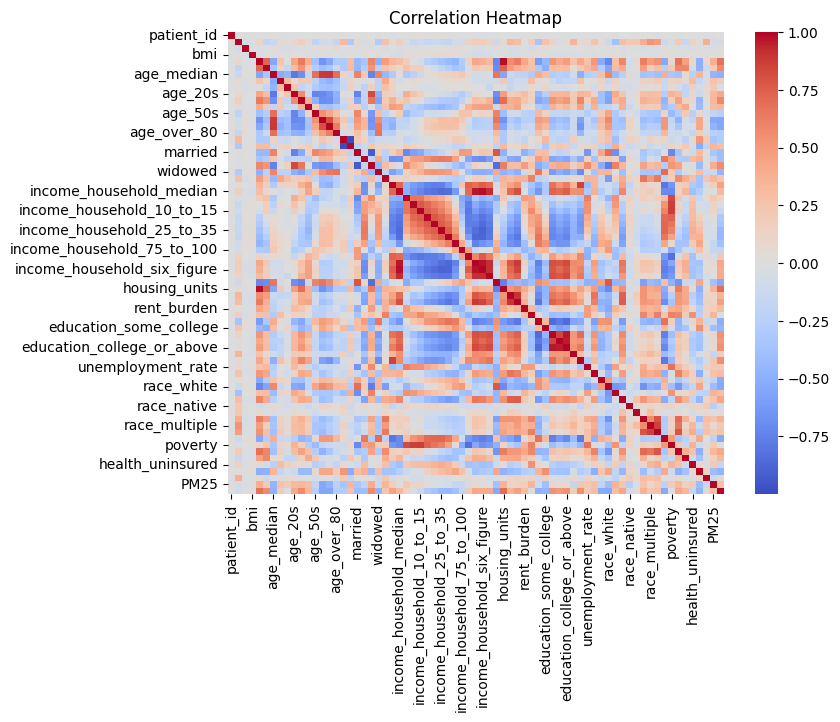

In [ ]:
df = pd.concat([train.drop(columns="DiagPeriodL90D"), test])
corr_matrix = df[nums].corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

#lasso cv
#shaps

In [ ]:
# Perform one-hot encoding
encoded_data = pd.get_dummies(train[cats])
                          #drop_first = True)
train = train.drop(cats, axis=1)
train = pd.concat([train, encoded_data], axis=1)

encoded_data = pd.get_dummies(test[cats])
test = test.drop(cats, axis=1)
test = pd.concat([test, encoded_data], axis=1)

In [ ]:
# strong_correlations = corr_matrix['DiagPeriodL90D'].abs().drop('DiagPeriodL90D')

# strong_correlations.sort_values(ascending=False)

In [ ]:
for index, value in test.isna().sum().items():
    if value > 0:
        print(index, value)

In [ ]:
df = pd.concat([train.drop(columns="DiagPeriodL90D"), test])

cols_not_common = []
for index, value in df.isna().sum().items():
    if value > 0:
        print(index, value)
        cols_not_common.append(index)

for col in cols_not_common:
  if col not in train.columns:
    train[col] = 0
  if col not in test.columns:
    test[col] = 0

test = test.reindex(columns=sorted(test.columns))
train = train.reindex(columns=sorted(train.columns))

df.fillna(0, inplace=True)

patient_state_CT 5792
patient_state_NH 5792
patient_state_PR 5792
patient_state_RI 5792
breast_cancer_diagnosis_code_1759 5792
breast_cancer_diagnosis_code_C50 5792
breast_cancer_diagnosis_code_C5001 5792
breast_cancer_diagnosis_code_C50021 5792
breast_cancer_diagnosis_code_C5011 5792
breast_cancer_diagnosis_code_C5051 5792
breast_cancer_diagnosis_desc_Malignant neoplasm of breast 5792
breast_cancer_diagnosis_desc_Malignant neoplasm of central portion of breast, female 5792
breast_cancer_diagnosis_desc_Malignant neoplasm of lower-outer quadrant of breast, female 5792
breast_cancer_diagnosis_desc_Malignant neoplasm of nipple and areola, female 5792
breast_cancer_diagnosis_desc_Malignant neoplasm of nipple and areola, right male breast 5792
breast_cancer_diagnosis_desc_Malignant neoplasm of other and unspecified sites of male breast 5792
metastatic_cancer_diagnosis_code_C7830 5792
metastatic_cancer_diagnosis_code_C784 5792
metastatic_cancer_diagnosis_code_C7901 5792
metastatic_cancer_dia

In [ ]:
for index, value in test.isna().sum().items():
    if value > 0:
        print(index, value)

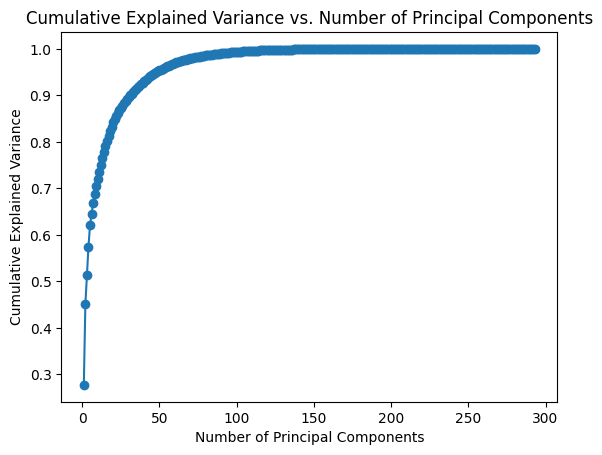

70


In [ ]:
pca = PCA()
pca.fit(df)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = explained_variance_ratio.cumsum()
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.show()

for i in cumulative_explained_variance.tolist():
  if i >= 0.98:
    print(cumulative_explained_variance.tolist().index(i))
    break

In [ ]:
pca = PCA(n_components = 69)

# pca then split
pca.fit(df)
pca_df = pd.DataFrame(pca.transform(df), columns = ([str(i) for i in range(1, 70)]))

pca_x = pca_df[:12906]
pca_test = pca_df[12906:]

# pca.fit(train.drop(columns="DiagPeriodL90D"))
# pca_x = pd.DataFrame(pca.transform(train.drop(columns="DiagPeriodL90D")), columns = ([str(i) for i in range(1, 70)]))

# pca.fit(test)
# pca_test = pd.DataFrame(pca.transform(test), columns = ([str(i) for i in range(1, 70)]))

In [ ]:
x = train.drop('DiagPeriodL90D', axis = 1)
y = train['DiagPeriodL90D']

In [ ]:
parameters = {'kernel': ['sigmoid', 'rbf'], 'C': [0.01, 0.1, 1, 5, 10, 25, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 'scale']}

In [ ]:
svc = svm.SVC(probability=True)

# Create GridSearchCV object
clf = GridSearchCV(svc, parameters, cv=5)

# Fit the GridSearchCV object to the data
clf.fit(x, y)

# Get the best parameters and the best score
best_params = clf.best_params_
print("Best parameters found:", best_params)

y_pred = clf.best_estimator_.predict(x)
accuracy = accuracy_score(y, y_pred)

y_proba = clf.best_estimator_.predict_proba(x)[:, 1]
auc = roc_auc_score(y, y_proba)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"AUC: {auc}")

y_test = clf.best_estimator_.predict(test)

In [ ]:
svc = svm.SVC(kernel='rbf', C=75, gamma=0.5)
svc.fit(x, y)
support_vectors = svc.support_vectors_
print(svc.n_support_)

y_pred = svc.predict(x)
accuracy = accuracy_score(y, y_pred)

y_proba = svc.predict_proba(pca_x)[:, 1]
auc = roc_auc_score(y, y_proba)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"AUC: {auc}")

In [ ]:
svc = svm.SVC(kernel='rbf', C=5, gamma=0.05)
svc.fit(x, y)
support_vectors = svc.support_vectors_
print(svc.n_support_)

y_pred = svc.predict(pca_x)
accuracy = accuracy_score(y, y_pred)

y_proba = svc.predict_proba(pca_x)[:, 1]
auc = roc_auc_score(y, y_proba)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"AUC: {auc}")

In [ ]:
svc = svm.SVC(kernel='rbf', C=10, gamma=0.01)
svc.fit(x, y)
support_vectors = svc.support_vectors_
print(svc.n_support_)

y_pred = svc.predict(pca_x)
accuracy = accuracy_score(pca_y, y_pred)

y_proba = svc.predict_proba(pca_x)[:, 1]
auc = roc_auc_score(pca_y, y_proba)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"AUC: {auc}")

In [ ]:
svc = svm.SVC(kernel='rbf', C=0.1, gamma=0.01)
svc.fit(x, y)
support_vectors = svc.support_vectors_
print(svc.n_support_)

y_pred = svc.predict(pca_x)
accuracy = accuracy_score(pca_y, y_pred)

y_proba = svc.predict_proba(pca_x)[:, 1]
auc = roc_auc_score(pca_y, y_proba)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"AUC: {auc}")

In [ ]:
# svc = svm.SVC(kernel='rbf', C=1, gamma='scale', probability=True)
# svc.fit(x, y)
# support_vectors = svc.support_vectors_
# print(svc.n_support_)

y_pred = svc.predict(x)
accuracy = accuracy_score(y, y_pred)

y_proba = svc.predict_proba(x)[:, 1]
auc = roc_auc_score(y, y_proba)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"AUC: {auc}")

In [ ]:
svc = svm.SVC(kernel='rbf', C=5, gamma='scale')
svc.fit(pca_x, pca_y)
support_vectors = svc.support_vectors_
print(svc.n_support_)

y_pred = svc.predict(pca_x)
accuracy = accuracy_score(pca_y, y_pred)

y_proba = svc.predict_proba(pca_x)[:, 1]
auc = roc_auc_score(pca_y, y_proba)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"AUC: {auc}")

In [ ]:
svc = svm.SVC(kernel='rbf', C=5, gamma=0.01)
svc.fit(pca_x, pca_y)
support_vectors = svc.support_vectors_
print(svc.n_support_)

y_pred = svc.predict(pca_x)
accuracy = accuracy_score(pca_y, y_pred)

y_proba = svc.predict_proba(pca_x)[:, 1]
auc = roc_auc_score(pca_y, y_proba)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"AUC: {auc}")

In [ ]:
svc = svm.SVC(kernel='rbf', C=10, gamma=0.05, probability=True)
svc.fit(pca_x, pca_y)
support_vectors = svc.support_vectors_
print(svc.n_support_)

y_pred = svc.predict(pca_x)
accuracy = accuracy_score(pca_y, y_pred)

y_proba = svc.predict_proba(pca_x)[:, 1]
auc = roc_auc_score(pca_y, y_proba)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"AUC: {auc}")

In [ ]:
svc = svm.SVC(kernel='rbf', C=1, gamma=0.05)
svc.fit(pca_x, pca_y)
support_vectors = svc.support_vectors_
print(svc.n_support_)

y_pred = svc.predict(pca_x)
accuracy = accuracy_score(pca_y, y_pred)

y_proba = svc.predict_proba(pca_x)[:, 1]
auc = roc_auc_score(pca_y, y_proba)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"AUC: {auc}")

In [ ]:
svc = svm.SVC(kernel='sigmoid', C=100, gamma=0.0001, probability=True)
svc.fit(pca_x, y)
support_vectors = svc.support_vectors_
print(svc.n_support_)

y_pred = svc.predict(pca_x)
accuracy = accuracy_score(y, y_pred)

y_proba = svc.predict_proba(pca_x)[:, 1]
auc = roc_auc_score(y, y_proba)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"AUC: {auc}")

[3305 3330]
Accuracy: 77.49%
AUC: 0.7407305557063254


In [ ]:
svc = svm.SVC(kernel='sigmoid', C=100, gamma=0.0001, probability=True)
svc.fit(x, y)
support_vectors = svc.support_vectors_
print(svc.n_support_)

y_pred = svc.predict(x)
accuracy = accuracy_score(y, y_pred)

y_proba = svc.predict_proba(x)[:, 1]
auc = roc_auc_score(y, y_proba)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"AUC: {auc}")

[2994 3612]
Accuracy: 80.95%
AUC: 0.7768623991135408


In [ ]:
# y_test = svc.predict(pca_test)
y_test = svc.predict(test)

In [ ]:
submission = pd.concat([patients, pd.Series(y_test, name='DiagPeriodL90D')], axis = 1)

submission.to_csv("submission.csv", index=False)

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

X_train = train.drop('DiagPeriodL90D', axis=1)
y_train = train['DiagPeriodL90D']

X_test = test

# Define base models
xgboost_model = xgb.XGBClassifier(n_estimators=450, max_depth=7, learning_rate=0.005)
gradient_boosting = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)

# Define meta-model
meta_model = LogisticRegression(C=0.01, penalty='l2', solver='lbfgs')

# Define feature stacking pipeline
stacking_pipeline = make_pipeline(StandardScaler(), meta_model)

# Generate predictions from base models using cross-validation
xgb_predictions = cross_val_predict(xgboost_model, X_train, y_train, cv=5, method='predict_proba')
gb_predictions = cross_val_predict(gradient_boosting, X_train, y_train, cv=5, method='predict_proba')

# Create new feature matrix for the meta-model using predictions from base models
X_meta = np.column_stack((xgb_predictions[:, 1], gb_predictions[:, 1]))

# Train the meta-model
stacking_pipeline.fit(X_meta, y_train)

# Fit the base models
xgboost_model.fit(X_train, y_train)
gradient_boosting.fit(X_train, y_train)

# Generate predictions from base models on the test set
xgb_test_predictions = xgboost_model.predict_proba(X_test)
gb_test_predictions = gradient_boosting.predict_proba(X_test)

# Create new feature matrix for the meta-model using predictions from base models on the test set
X_test_meta = np.column_stack((xgb_test_predictions[:, 1], gb_test_predictions[:, 1]))

# Make predictions using the meta-model
prediction = stacking_pipeline.predict_proba(X_test_meta)[:, 1]

# Save predictions to submission file
sample["DiagPeriodL90D"] = prediction
sample.to_csv("submission.csv", index=False)
